In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time
import copy

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready

from utils import plot_learning
from envs.single_photon_env import SinglePhotonLangevinReadoutEnv
from env_configs import get_sherbrooke_config, get_kyoto_config

from rl_algos.ppo_continuous import PPO_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [24]:
# Defining Sherbrooke Params and RL Params

s_config = get_sherbrooke_config()
s_env_config = copy.deepcopy(s_config)
s_off_config = copy.deepcopy(s_config)
s_high_config = copy.deepcopy(s_config)
err = 0.05
s_off_config["chi"] = (1. - err) * s_off_config["chi"]
s_high_config["chi"] = (1. + err) * s_high_config["chi"]

num_envs = 256
num_updates = 5000
config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": s_env_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

off_config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": s_off_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

high_config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": s_high_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

In [25]:
s_env_config

{'kappa': 14.31,
 'chi': 1.9477874452256718,
 'kerr': 0.0,
 'time_coeff': 1.0,
 'snr_coeff': 20.0,
 'smoothness_coeff': 1.0,
 'smoothness_baseline_scale': 1.0,
 'gauss_kernel_len': 15,
 'gauss_kernel_std': 2.0,
 'bandwidth': 50.0,
 'freq_relative_cutoff': 0.1,
 'bandwidth_coeff': 0.0,
 'n0': 53.8,
 'tau_0': 0.783,
 'res_amp_scaling': 2.873563218390805,
 'nR': 0.05,
 'snr_scale_factor': 1.25,
 'gamma_I': 0.002755580049600441,
 'photon_gamma': 0.00025,
 'sim_t1': 0.63,
 'init_fid': 1.0,
 'photon_weight': 12.0,
 'standard_fid': 0.99,
 'shot_noise_std': 0.0}

In [26]:
s_off_config

{'kappa': 14.31,
 'chi': 1.850398072964388,
 'kerr': 0.0,
 'time_coeff': 1.0,
 'snr_coeff': 20.0,
 'smoothness_coeff': 1.0,
 'smoothness_baseline_scale': 1.0,
 'gauss_kernel_len': 15,
 'gauss_kernel_std': 2.0,
 'bandwidth': 50.0,
 'freq_relative_cutoff': 0.1,
 'bandwidth_coeff': 0.0,
 'n0': 53.8,
 'tau_0': 0.783,
 'res_amp_scaling': 2.873563218390805,
 'nR': 0.05,
 'snr_scale_factor': 1.25,
 'gamma_I': 0.002755580049600441,
 'photon_gamma': 0.00025,
 'sim_t1': 0.63,
 'init_fid': 1.0,
 'photon_weight': 12.0,
 'standard_fid': 0.99,
 'shot_noise_std': 0.0}

In [27]:
s_high_config

{'kappa': 14.31,
 'chi': 2.0451768174869556,
 'kerr': 0.0,
 'time_coeff': 1.0,
 'snr_coeff': 20.0,
 'smoothness_coeff': 1.0,
 'smoothness_baseline_scale': 1.0,
 'gauss_kernel_len': 15,
 'gauss_kernel_std': 2.0,
 'bandwidth': 50.0,
 'freq_relative_cutoff': 0.1,
 'bandwidth_coeff': 0.0,
 'n0': 53.8,
 'tau_0': 0.783,
 'res_amp_scaling': 2.873563218390805,
 'nR': 0.05,
 'snr_scale_factor': 1.25,
 'gamma_I': 0.002755580049600441,
 'photon_gamma': 0.00025,
 'sim_t1': 0.63,
 'init_fid': 1.0,
 'photon_weight': 12.0,
 'standard_fid': 0.99,
 'shot_noise_std': 0.0}

In [28]:
env = SinglePhotonLangevinReadoutEnv(**config["ENV_PARAMS"])

In [29]:
off_env = SinglePhotonLangevinReadoutEnv(**off_config["ENV_PARAMS"])

In [30]:
high_env = SinglePhotonLangevinReadoutEnv(**high_config["ENV_PARAMS"])

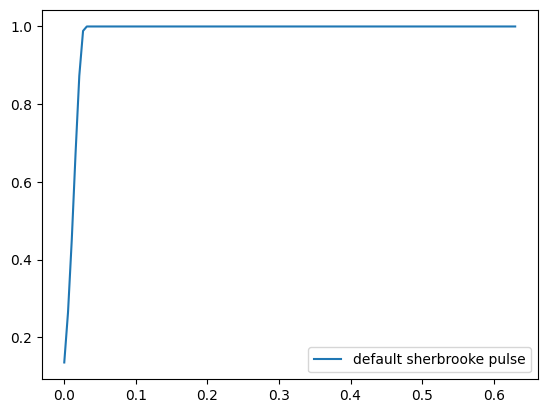

In [31]:
# Default Sherbrooke Action

ts = env.ts_action

gauss_sigma = 0.0142
num_sigma = 2.
total_duration = s_env_config["tau_0"]

default_pulse = jnp.heaviside((total_duration - num_sigma * gauss_sigma) - ts, 1.) * jnp.heaviside(ts - num_sigma * gauss_sigma, 0.)
default_pulse += jnp.heaviside(num_sigma * gauss_sigma - ts, 1.) * jnp.exp(-(ts - num_sigma * gauss_sigma)**2 / (2 * gauss_sigma**2))
default_pulse += jnp.heaviside(ts - (total_duration - num_sigma * gauss_sigma), 1.) * jnp.exp(-(ts - (total_duration - num_sigma * gauss_sigma))**2 / (2 * gauss_sigma**2))

plt.plot(ts, default_pulse, label='default sherbrooke pulse')
plt.legend()
plt.show()

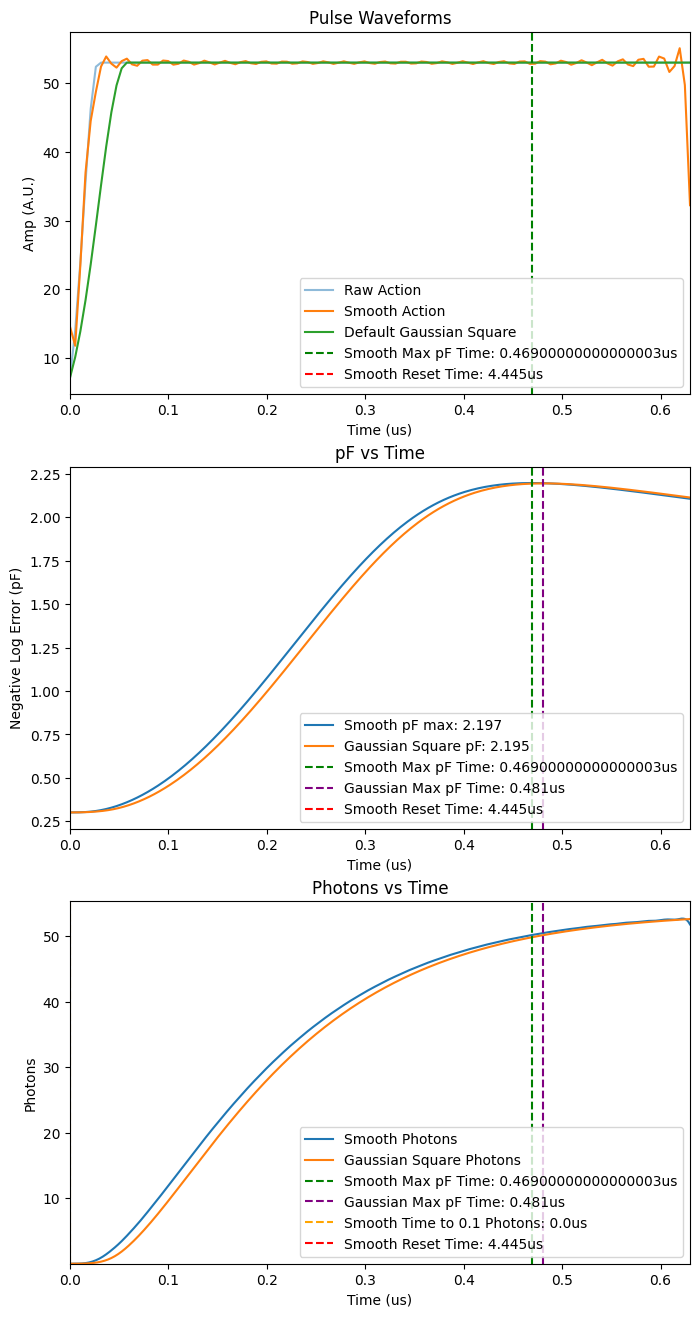

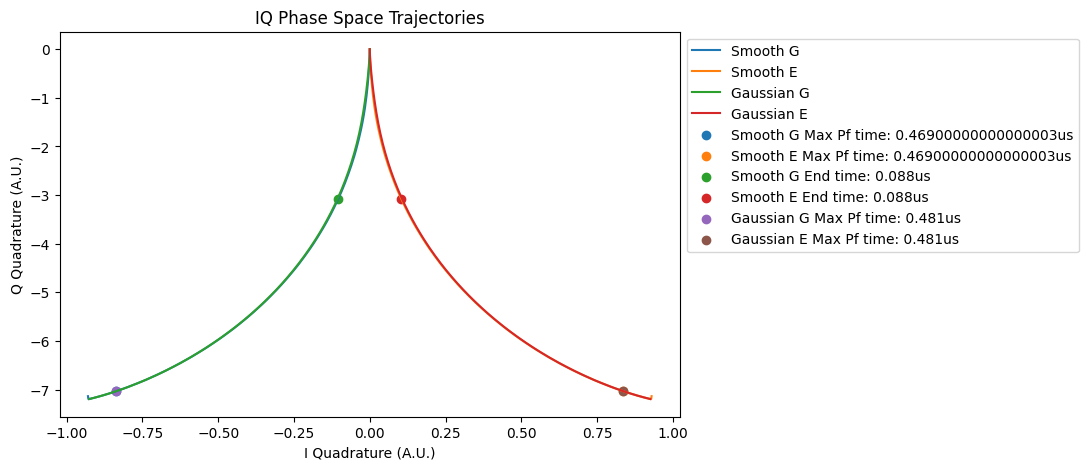

In [32]:
env.rollout_action(_rng, default_pulse)

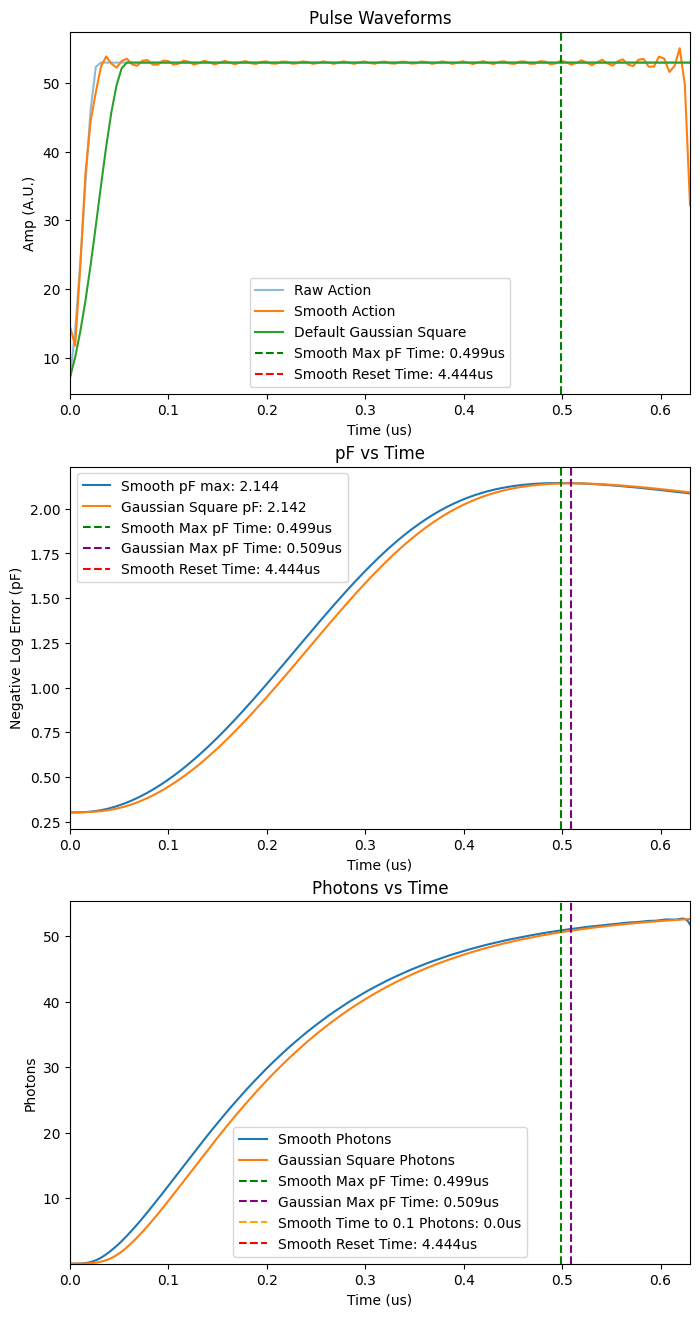

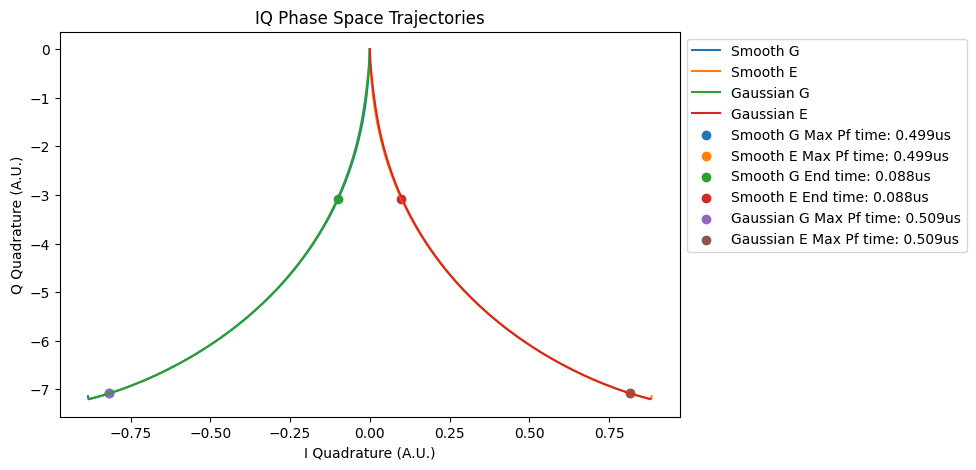

In [33]:
off_env.rollout_action(_rng, default_pulse)

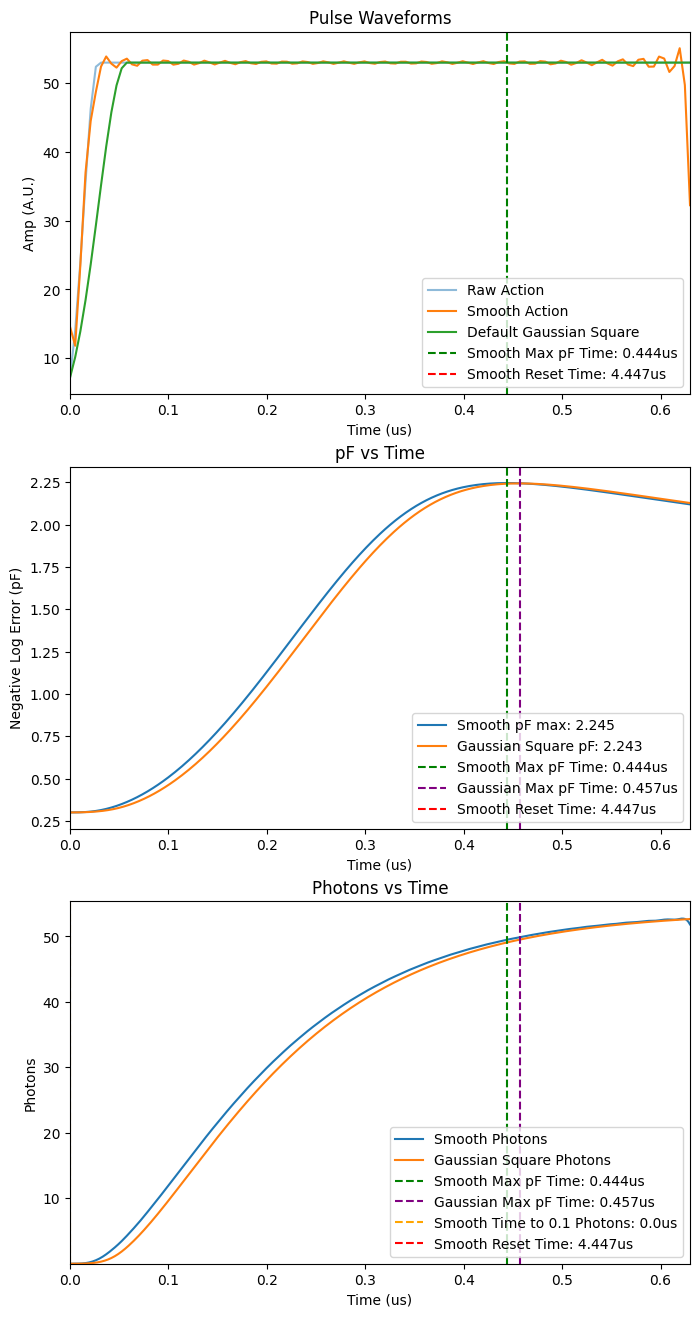

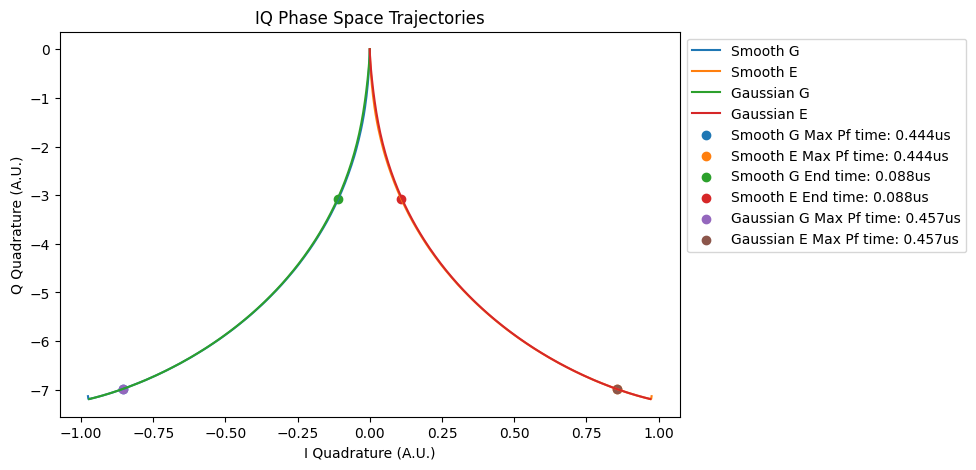

In [34]:
high_env.rollout_action(_rng, default_pulse)

## Low
### Kappa
Duration: 462ns
pF: 2.23

### Chi
Duration: 499ns
pF: 2.144

## Normal
### Kappa
Duration: 469ns
pF: 2.197

### Chi
Duration: 469ns
pF: 2.197

## High
### Kappa
Duration: 478ns
pF: 2.162

### Chi
Duration: 444ns
pF: 2.245

In [18]:
import pandas as pd

stability_actions = np.load('Smooth Final Action Batch Fig 4.npy')
stability_df = pd.read_csv('fig 4 pFs and times')

stability_df.head()

,Unnamed: 0,kappas,chis,pFs from 0th action of batch,times from 0th action of batch,pFs from mean action,times from mean action,times from mean action to 0.1 photons
0,0,13.5945,1.850398,2.229631,0.419265,2.230940,0.421425,0.405405
1,1,14.3100,1.850398,2.228306,0.440055,2.225479,0.438323,0.418702
2,2,15.0255,1.850398,2.197127,0.426195,2.196273,0.426195,0.382882
3,3,13.5945,1.947787,2.226457,0.469508,2.233195,0.433125,0.429779
4,4,14.3100,1.947787,2.205454,0.405405,2.208597,0.402436,0.394282


In [19]:
stability_actions.shape

(9, 256, 121)

In [21]:
mean_stability_actions = jnp.mean(stability_actions, axis=1)
mean_stability_actions.shape

(9, 121)

In [36]:
mean_pFs = stability_df["pFs from mean action"].to_numpy()
mean_times = stability_df["times from mean action"].to_numpy()
kappas = stability_df["kappas"].to_numpy()
chis = stability_df["chis"].to_numpy()

kappas

array([13.5945, 14.31  , 15.0255, 13.5945, 14.31  , 15.0255, 13.5945,
       14.31  , 15.0255])

In [37]:
chis

array([1.85039807, 1.85039807, 1.85039807, 1.94778745, 1.94778745,
       1.94778745, 2.04517682, 2.04517682, 2.04517682])

In [38]:
k_action_low = mean_stability_actions[3]
k_action_og = mean_stability_actions[4]
k_action_high = mean_stability_actions[5]

c_action_low = mean_stability_actions[1]
c_action_og = mean_stability_actions[4]
c_action_high = mean_stability_actions[7]

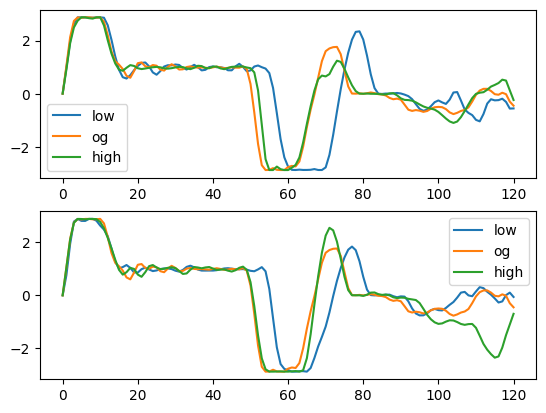

In [46]:
fig, ax =  plt.subplots(2)

ax[0].plot(-k_action_low, label='low')
ax[0].plot(-k_action_og, label='og')
ax[0].plot(-k_action_high, label='high')
ax[0].legend()

ax[1].plot(c_action_low, label='low')
ax[1].plot(-c_action_og, label='og')
ax[1].plot(c_action_high, label='high')
ax[1].legend()

plt.show()

## Testing Vary Chi Actions

In [42]:
raw_actions = np.load('final action batch fig 4.npy')
raw_actions.shape

(9, 256, 121)

In [43]:
mean_raw_actions = jnp.mean(raw_actions, axis=1)
mean_raw_actions.shape

(9, 121)

In [44]:
k_raw_low = mean_raw_actions[3]
k_raw_og = mean_raw_actions[4]
k_raw_high = mean_raw_actions[5]

c_raw_low = mean_raw_actions[1]
c_raw_og = mean_raw_actions[4]
c_raw_high = mean_raw_actions[7]

In [50]:
k_0_low = raw_actions[3, 0]
k_0_og = raw_actions[4, 0]
k_0_high = raw_actions[5, 0]

c_0_low = raw_actions[1, 0]
c_0_og = raw_actions[4, 0]
c_0_high = raw_actions[7, 0]

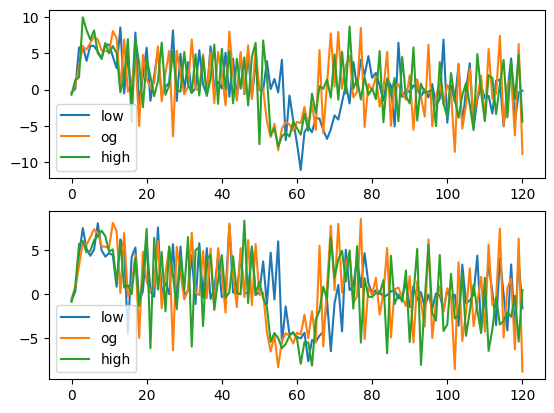

In [47]:
fig, ax =  plt.subplots(2)

ax[0].plot(-k_raw_low, label='low')
ax[0].plot(-k_raw_og, label='og')
ax[0].plot(-k_raw_high, label='high')
ax[0].legend()

ax[1].plot(c_raw_low, label='low')
ax[1].plot(-c_raw_og, label='og')
ax[1].plot(c_raw_high, label='high')
ax[1].legend()

plt.show()

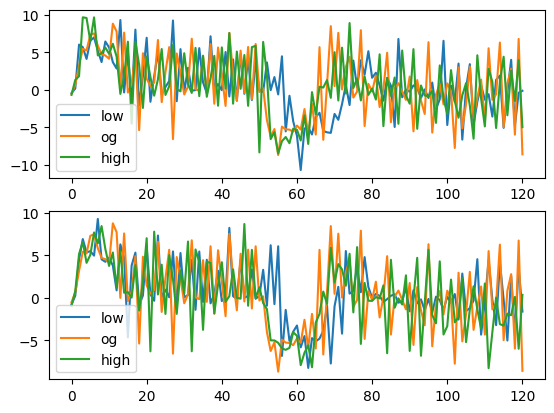

In [51]:
fig, ax =  plt.subplots(2)

ax[0].plot(-k_0_low, label='low')
ax[0].plot(-k_0_og, label='og')
ax[0].plot(-k_0_high, label='high')
ax[0].legend()

ax[1].plot(c_0_low, label='low')
ax[1].plot(-c_0_og, label='og')
ax[1].plot(c_0_high, label='high')
ax[1].legend()

plt.show()

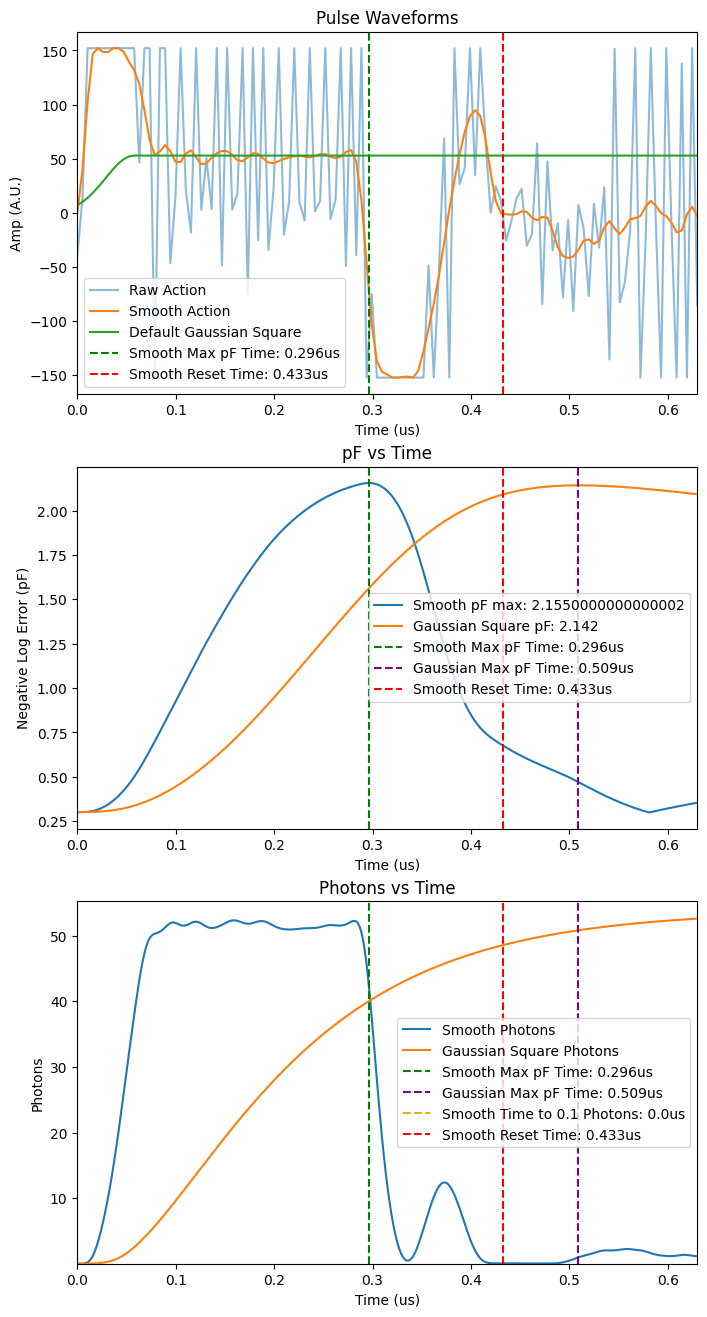

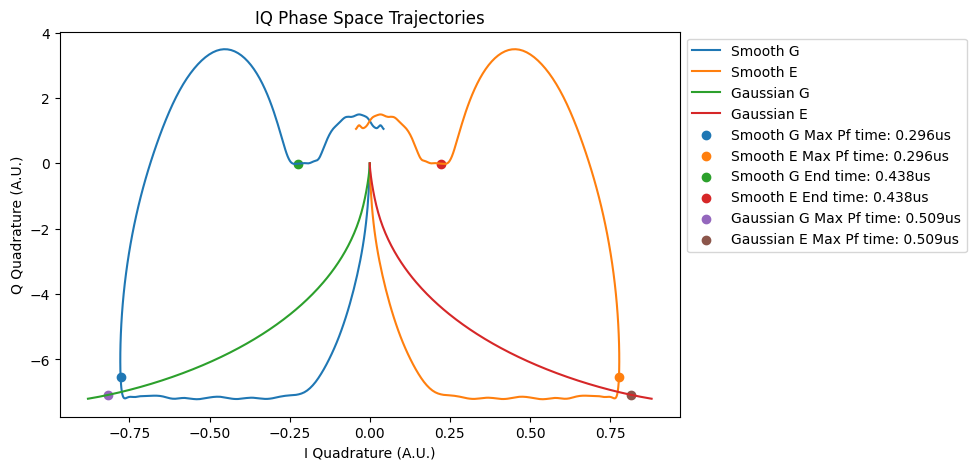

In [52]:
off_env.rollout_action(_rng, c_0_low)

In [49]:
mean_pFs

array([2.23094018, 2.22547854, 2.19627256, 2.23319517, 2.20859701,
       2.20323231, 2.21102831, 2.20243666, 2.2051125 ])

In [56]:
mean_times

array([0.42142526, 0.4383225 , 0.426195  , 0.433125  , 0.40243619,
       0.43659   , 0.39691523, 0.39705613, 0.43514827])

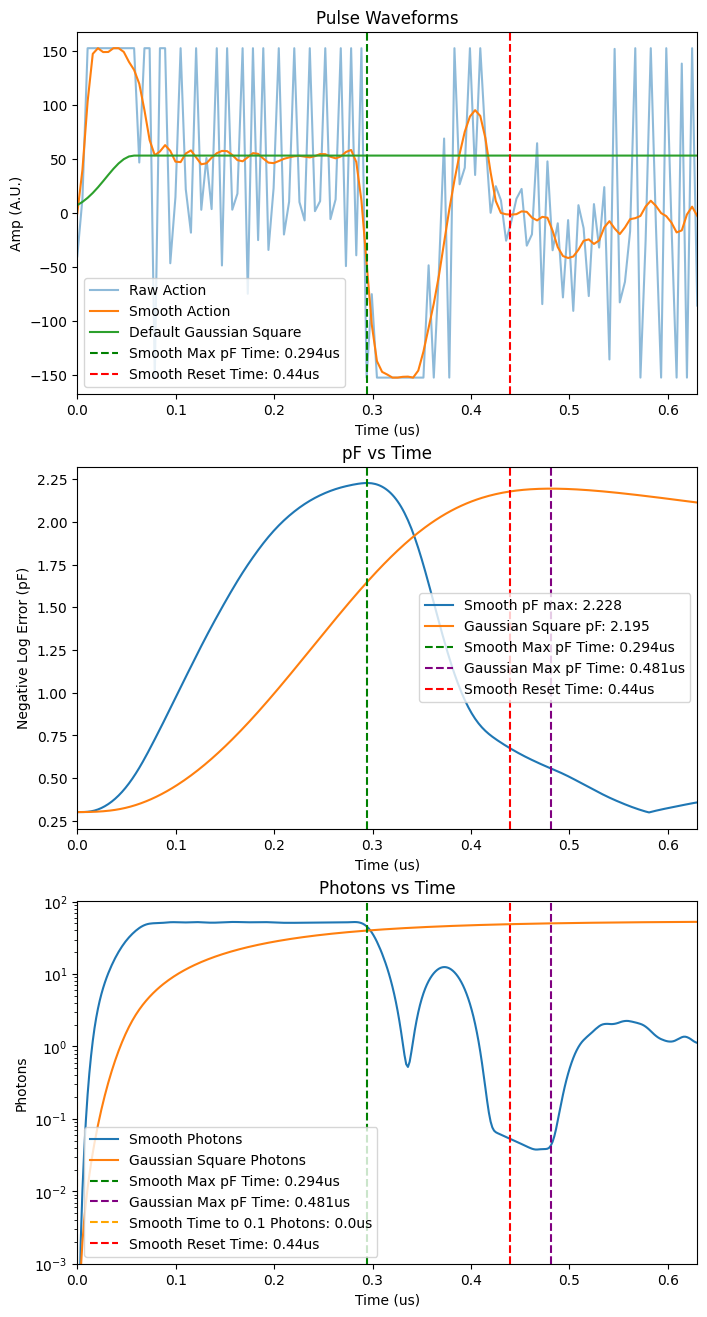

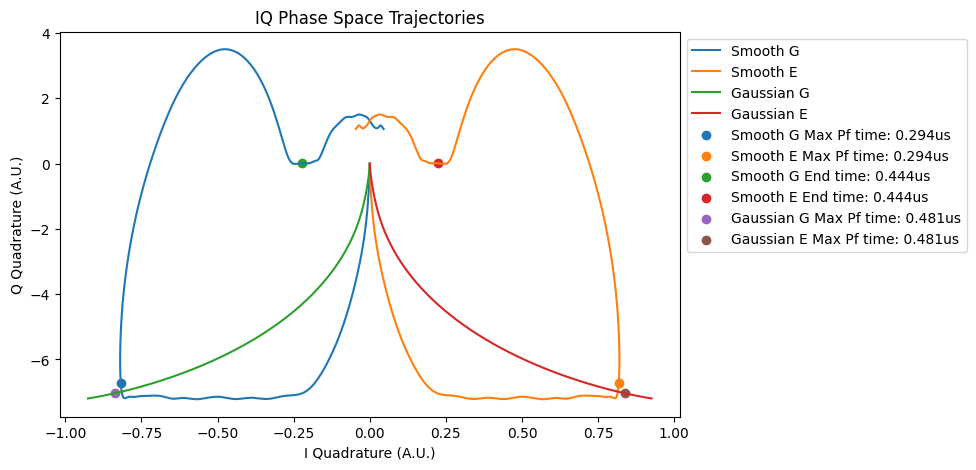

In [58]:
env.rollout_action(_rng, c_0_low, photon_log_scale=True)

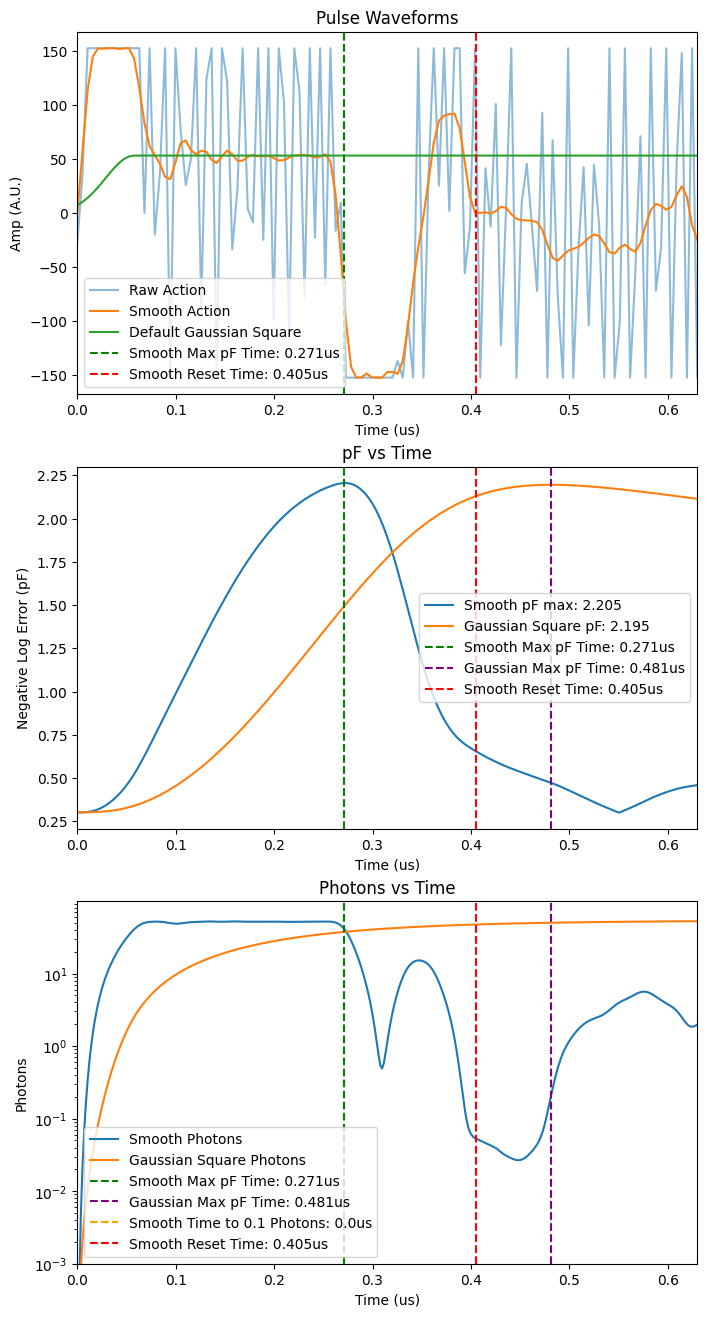

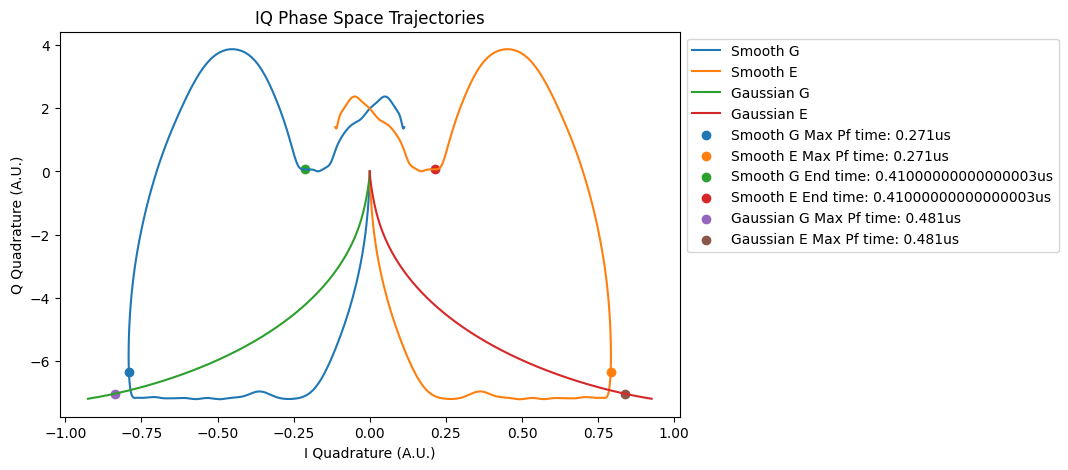

In [57]:
env.rollout_action(_rng, -c_0_og, photon_log_scale=True)

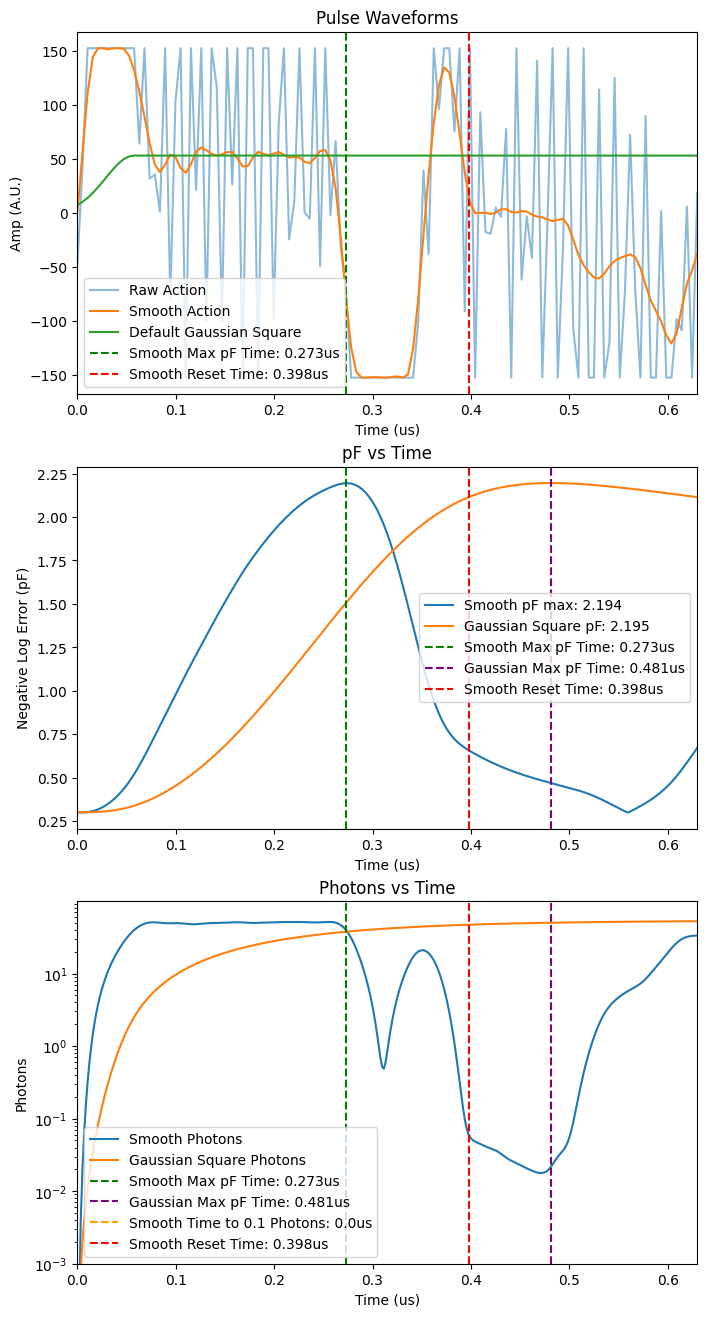

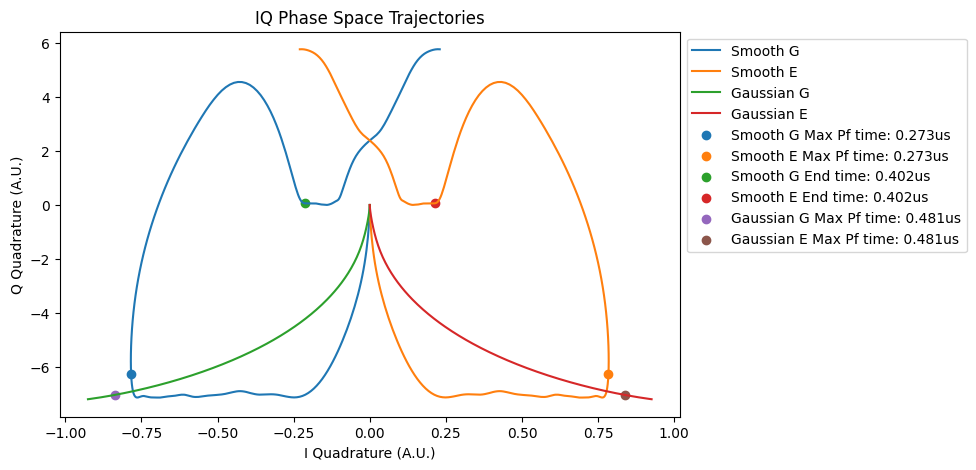

In [60]:
env.rollout_action(_rng, c_0_high, photon_log_scale=True)

## Appropriately Comparing Mis-calibrated Chi-Kappa

If fidelity params are constant, and we are in the high kappa-chi regime, then the first segment and the readout segment should be the same (readout should be calibrated such that the fidelity segments take the same time).

[[13.5945 14.31   15.0255]
 [13.5945 14.31   15.0255]
 [13.5945 14.31   15.0255]]
[[1.85039807 1.85039807 1.85039807]
 [1.94778745 1.94778745 1.94778745]
 [2.04517682 2.04517682 2.04517682]]


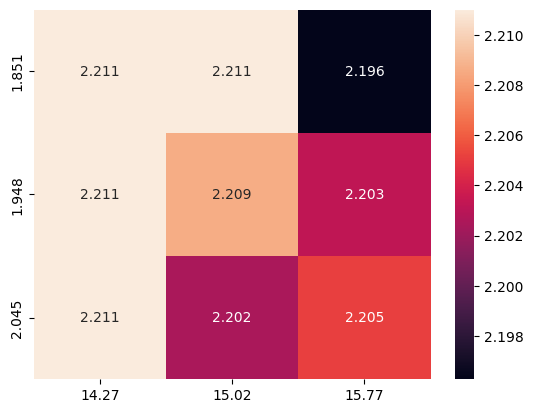

In [74]:
import seaborn as sns

from utils import get_kc_arrs

print(kappas.reshape(3, 3))
print(chis.reshape(3, 3))

kappa = kappas[5]
chi = chis[5]

k_arr, c_arr, _, _ = get_kc_arrs(kappa, chi, err)

k_arr = jnp.round(k_arr.astype(jnp.float16), decimals=2)
c_arr = jnp.round(c_arr.astype(jnp.float16), decimals=3)

mean_pFs_heatmap = mean_pFs.clip(min=None, max=2.211)

plt.figure()
sns.heatmap(
    mean_pFs_heatmap.reshape(3, 3),
    annot=True,
    fmt='.3f',
    xticklabels=k_arr,
    yticklabels=c_arr
)
plt.show()

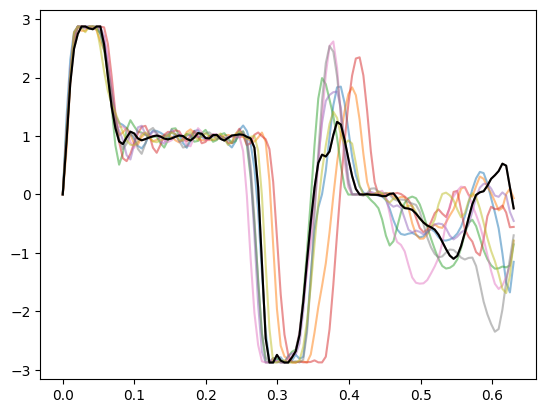

In [80]:
positive_actions = mean_stability_actions * jnp.sign(mean_stability_actions[:, 3]).reshape(-1, 1)

plt.plot(ts, positive_actions.T, alpha=0.5)
plt.plot(ts, positive_actions[5], color='black')
plt.show()